# WHALES AND DOLPHINS CNN ##

*A CNN Model*

## Overview
Although this competition's goal was to find each individual, for this notebook our goal will be to identify species (instead of specific individuals). We do this to make computer vision classification using transfer learning more accessible by using fewer classes. In addition, being able to identify species can be extremely useful in real-life situations such as marine biology. For example, monitoring migration routes which can change due to human interaction and/or climate change. This study opens the door to further research on marine life. In this notebook, we will cover EDA as well as two different model architectures. Finally, we will cover our results at the end of the notebook. 

Competition Link: https://www.kaggle.com/competitions/happy-whale-and-dolphin

Data Source: https://www.kaggle.com/competitions/happy-whale-and-dolphin/data 

For direct data download: https://www.kaggle.com/competitions/happy-whale-and-dolphin/data#:~:text=get_app-,Download,-All or command line as >_ kaggle competitions download -c happy-whale-and-dolphin

This notebook has the follow layout:
1. Brief Description of the Problem and Data
2. Exploratory Data Analysis (EDA) and Preprocessing
3. Model Construction and Architecture
4. Results and Analysis
5. Conclusion

In [1]:
#import libraries
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from skimage import io
from skimage.color import rgb2gray
import plotly.express as px
import random
from sklearn.utils import shuffle
import shutil
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#check tensorflow verison
tf.__version__

'2.6.2'

In [3]:
#get global path
global_path = "/kaggle/input/happy-whale-and-dolphin/"
os.listdir(global_path)

['sample_submission.csv', 'train_images', 'train.csv', 'test_images']

In [4]:
#set paths
sample_submission_path = "/kaggle/input/happy-whale-and-dolphin/sample_submission.csv"
train_images_path = "/kaggle/input/happy-whale-and-dolphin/train_images/"
train_path = "/kaggle/input/happy-whale-and-dolphin/train.csv"
test_images_path = "/kaggle/input/happy-whale-and-dolphin/test_images/"

# 1. Brief Description of the Problem and Data

Whales and dolphins are a key component for the marine ecosystem so being able to identify species could be helpful for other research projects. In this project, we are given 51033 images which are connected to the training dataframe, in which we are given the columns 'image id' (as jpg), 'species', and 'individual_id'. Again, we will not be trying to identify the individual_id column, instead we will try to identify the species columns based on computer vision techniques. We also are given testing images, which in our case we will not use since the testing data is just images with no way to know the species to compare. We also note that we do not have bounding boxes on the images and all the images are different shapes and resolutions.

In other words:
* 51033 images of different sizes/dimensions. 
* Images have 3 color channels.
* Train images are saved as jpg in a unique folder ('train_images') 
* Train dataframe (given as a CSV file) has 3 columns (image, species, individual_id) with 51033 entries.
* We are given the test images but since we will not be modeling individual_id (we will model for species instead) we don't need the test_images folder. 
* 30 unique species
* No missing entries in dataframe

In [5]:
#view data
train_data = pd.read_csv(train_path)
train_data.head()   

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


In [6]:
########### TEST ##########
'''
This cell is used to do quick debugging and make sure 
all cells run, prior to running all the images. You can 
run this notebook as such if you don't want to wait for 
all images. Simply uncomment below'''

#train_data = train_data[0:100]

"\nThis cell is used to do quick debugging and make sure \nall cells run, prior to running all the images. You can \nrun this notebook as such if you don't want to wait for \nall images. Simply uncomment below"

In [7]:
#training data information and data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51033 entries, 0 to 51032
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          51033 non-null  object
 1   species        51033 non-null  object
 2   individual_id  51033 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [8]:
#number of missing data
train_data.isna().sum()

image            0
species          0
individual_id    0
dtype: int64

In [9]:
#describe data
train_data.describe()

,image,species,individual_id
count,51033,51033,51033
unique,51033,30,15587
top,00021adfb725ed.jpg,bottlenose_dolphin,37c7aba965a5
freq,1,9664,400


In [10]:
# find unique species
print(train_data['species'].unique())

['melon_headed_whale' 'humpback_whale' 'false_killer_whale'
 'bottlenose_dolphin' 'beluga' 'minke_whale' 'fin_whale' 'blue_whale'
 'gray_whale' 'southern_right_whale' 'common_dolphin' 'kiler_whale'
 'pilot_whale' 'dusky_dolphin' 'killer_whale' 'long_finned_pilot_whale'
 'sei_whale' 'spinner_dolphin' 'bottlenose_dolpin' 'cuviers_beaked_whale'
 'spotted_dolphin' 'globis' 'brydes_whale' 'commersons_dolphin'
 'white_sided_dolphin' 'short_finned_pilot_whale' 'rough_toothed_dolphin'
 'pantropic_spotted_dolphin' 'pygmy_killer_whale' 'frasiers_dolphin']


# 2. Exploratory Data Analysis (EDA) and Preprocessing

In our exploration of data, we will plot the counts of species as well as visualize some of our images. We first must correct misspellings and groupings. In addition, using our knowledge of dolphins and whales, we will plot how many of each we have as well. During model construction, we will crop the images and we will normalize them as well which is part of the preprocessing step.

We see there are 30 unique species. However, there are also some misspellings. We will fix the misspelling errors. We also notice that 'globis' is a term for a pilot whale so we will also group those in one. It is also important to note that killer whales and pilot whales (including short-finned and long-finned pilot whales) are actually a type of dolphin.

On a discussion board in Kaggle, the competition host clarifies the species: "long_finned_pilot_whale and short_finned_pilot_whale are very similar species where we would expect more variation between individuals than between species. pilot_whale and globis are both short_finned_pilot_whale and thus the three can be merged." https://www.kaggle.com/c/happy-whale-and-dolphin/discussion/305468


Note that more **data preprocessing** for the images will actually be done during the batching and running of the model. Due to space limitations, if we were to edit each image and save it, we would waste time and most likely use up much valuable memory space. For our preprocessing, we will be using ImageDataGenerator which allows us to modify/augment images as we batch them. In that step, we will normalize the images and split into training and testing set. We also will randomly flip them vertically and/or rotate the images. We do this to allow the model to learn more image possiblities of what fin positions could be. We also will have all images resized to 64x64x3 so they are all standard for the model to learn. Finally, after much delibertion and sleepless nights for waiting for the model to train, we have decided to greatly reduce the number of species (and therefore images) that we train the model with. Additionally, the species are quite unbalanced so by reducing the image count, we are making the species counts more balanced which can result in stronger models. As for training speed, I'm not sure why (and if you can tell me in the comments I would appreciate it) but the model runs mostly on CPU and takes more than an hour to train each epoch in both models. For these two reasons (time to train and unbalanced sets), in this section we will also reduce the number of images to work with. 

Summary of preprocessing steps we will perform:
* Fix misspellings
* Properly group whales and dolphins
* Normalize images (multiply by 1/255)
* Crop images to 64x64 pixel and 3 channels (64, 64, 3) 
* Split into training-validation sets (80-20 split) 
* Randomly flip vertically (augment images) 
* Randomly rotate up to 45 degrees (augment images) 

In [11]:
# fix misspellings
train_data['species'].replace({'bottlenose_dolpin':'bottlenose_dolphin',  #missing the 'h' in dolphin
                               'kiler_whale': 'killer_whale',             #missing the 'l' in killer
                               'globis':'pilot_whale',                    #correcting and merging species names
                               'short_finned_pilot_whale': 'pilot_whale', #merge pilot whales species names
                               'long_finned_pilot_whale':'pilot_whale'},  #merge merge pilot whales
                              inplace=True)

In [12]:
# actual number of unique speceis
print(f'Number of Species: {train_data["species"].nunique()}')

Number of Species: 25


After fixing the mispelling and labels in species, we actually have 26 different species we're working with. We see that some species have many more recordings than others. Specifically, the bottlenose dolphin has the most photos while the fraisers dolphin has the least. Since the bottlenose dolphin has so many more counts than the rest, we may run into unbalanced dataset training difficulties. which we will fix later in this section.

In [13]:
#species counts
train_data['species'].value_counts()

bottlenose_dolphin           10781
beluga                        7443
humpback_whale                7392
blue_whale                    4830
false_killer_whale            3326
dusky_dolphin                 3139
killer_whale                  2455
spinner_dolphin               1700
melon_headed_whale            1689
minke_whale                   1608
fin_whale                     1324
gray_whale                    1123
pilot_whale                    983
southern_right_whale           866
spotted_dolphin                490
sei_whale                      428
common_dolphin                 347
cuviers_beaked_whale           341
white_sided_dolphin            229
brydes_whale                   154
pantropic_spotted_dolphin      145
commersons_dolphin              90
pygmy_killer_whale              76
rough_toothed_dolphin           60
frasiers_dolphin                14
Name: species, dtype: int64

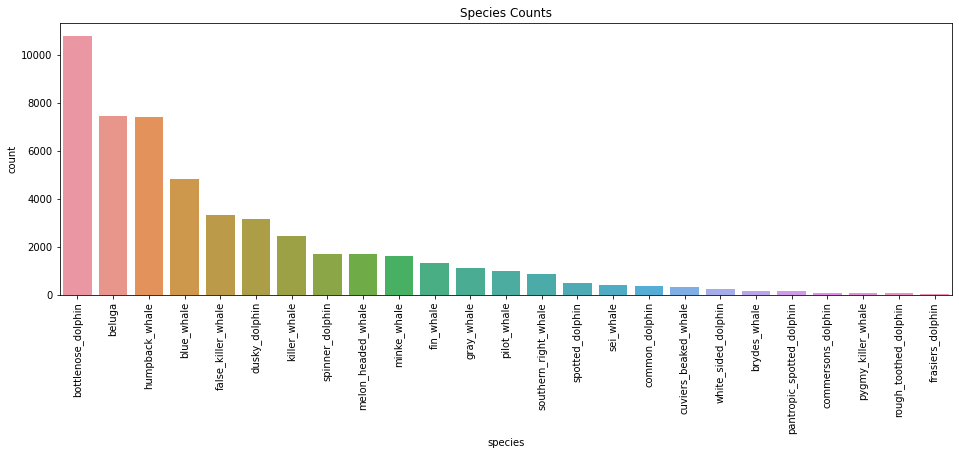

In [14]:
#plot species counts so that its easier to visualize
fig = plt.figure(figsize=(16, 5))
sns.countplot(x=train_data['species'],
            order=train_data['species'].value_counts().index).set(title='Species Counts')
plt.xticks(rotation=90);

Now let's visualize whales and dolphin and compare the spread. It is important to note that beluga's are whales and that the following animals are actually part of the dolphin family:
1. Killer whale
2. False killer whale
3. Pigmy killer whale
4. Melon-headed whale
5. Southern Right whale
6. Short finned pilot whale
7. Long finned pilot whale

Therefore, we will create a new column and categorize the animals. Then we will visualize them.

In [15]:
#declare dolphins and whales
dolphins = ['melon_headed_whale', 'false_killer_whale',
            'bottlenose_dolphin', 'southern_right_whale',
            'common_dolphin', 'killer_whale',
            'dusky_dolphin', 'pilot_whale', 'sei_whale',
            'spinner_dolphin', 'spotted_dolphin',
            'commersons_dolphin', 'white_sided_dolphin',
            'rough_toothed_dolphin', 'pantropic_spotted_dolphin',
            'pygmy_killer_whale', 'frasiers_dolphin']

whales = ['humpback_whale','beluga', 'minke_whale', 'fin_whale','blue_whale', 'gray_whale',
         'cuviers_beaked_whale', 'brydes_whale']

#add new column to dataframe with correct classification (whale or dolphin)
train_data['family'] = 'dolphin'
for index in range(len(train_data)):
    if train_data.species[index] in whales:
        train_data.family[index] = 'whale'

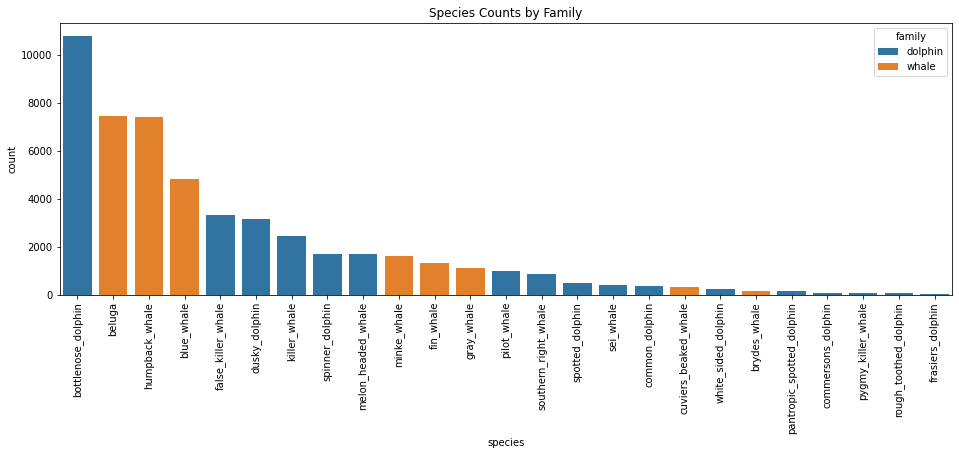

In [16]:
#visualize dolphins and whale counts
fig = plt.figure(figsize=(16, 5))
sns.countplot(x=train_data['species'],
              order=train_data['species'].value_counts().index, 
              hue=train_data['family'],
              dodge=False).set(title='Species Counts by Family')
plt.xticks(rotation=90);

Great! Above we see we have alot of bottlenose dolphin images and very few of the rough-toothed dolphin and fraisers dolphin. These values are quite unbalanced!

Below we see we have 47.4% whales and 52.6% dolphins which is quite close; our dataset is quite balance with regards to whales vs. dolphins. Too bad we were are not just classifying into two groups! But, not to worry because we have 25 groups to classify later on.  

In [17]:
# visualize as a pie chart
fig = px.pie(train_data, values = train_data['family'].value_counts().values, names = train_data['family'].unique())
fig.show()

Now that we have a better idea of what kind of data we have to identify the animals, let's take a look at the images we are given. However, before that let's take care of our uneven/unbalanced datasets. Since we have very uneven class sizes, we will delete the species that appear >900 times. In addition, we will randomly delete a percentage of the species which have many many more images than the others (for example, bottlenose dolphins).

In [18]:
#delete species with <900 images
rare_species = ['brydes_whale', 'pantropic_spotted_dolphin', 'commersons_dolphin', 'pygmy_killer_whale', 
                'rough_toothed_dolphin', 'frasiers_dolphin', 'white_sided_dolphin', 'cuviers_beaked_whale',
                'common_dolphin', 'sei_whale', 'spotted_dolphin', 'southern_right_whale','pilot_whale', 
                'gray_whale', 'fin_whale', 'minke_whale', 'melon_headed_whale', 'spinner_dolphin']
print(f'We will delete these species: {rare_species}')

#delete the rare species
for species in rare_species: 
    train_data = train_data[train_data['species'] != species]

We will delete these species: ['brydes_whale', 'pantropic_spotted_dolphin', 'commersons_dolphin', 'pygmy_killer_whale', 'rough_toothed_dolphin', 'frasiers_dolphin', 'white_sided_dolphin', 'cuviers_beaked_whale', 'common_dolphin', 'sei_whale', 'spotted_dolphin', 'southern_right_whale', 'pilot_whale', 'gray_whale', 'fin_whale', 'minke_whale', 'melon_headed_whale', 'spinner_dolphin']


In [19]:
print("We have way too many of these species: bottlenose_dolphin, beluga, humpback_whale.")

#randomly delete 50% (about 5000 total) of bottlenose dolphin images
train_data = train_data.drop(train_data[train_data['species'] == 'bottlenose_dolphin'].sample(frac=.5).index)

#randomly delete 30% 
train_data = train_data.drop(train_data[train_data['species'] == 'beluga'].sample(frac=.3).index)
train_data = train_data.drop(train_data[train_data['species'] == 'humpback_whale'].sample(frac=.3).index)

We have way too many of these species: bottlenose_dolphin, beluga, humpback_whale.


In [20]:
#reset index after deleting rows
train_data = train_data.reset_index(drop=True)

In [21]:
#double check new species counts
train_data['species'].value_counts()

bottlenose_dolphin    5391
beluga                5210
humpback_whale        5174
blue_whale            4830
false_killer_whale    3326
dusky_dolphin         3139
killer_whale          2455
Name: species, dtype: int64

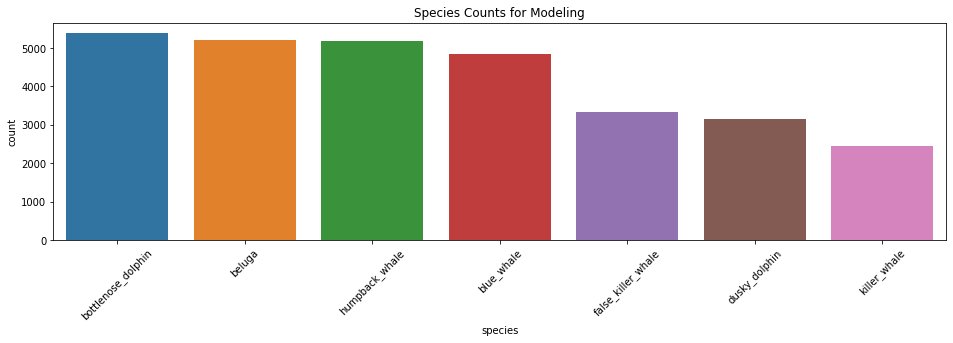

In [22]:
#visualize species for model
fig = plt.figure(figsize=(16, 4))
sns.countplot(x=train_data['species'],
            order=train_data['species'].value_counts().index).set(title='Species Counts for Modeling')
plt.xticks(rotation=45);

Great! It looks like we have 7 unique species and a much more balanced dataset! Now let's go ahead by checking the image shapes and visualize some of these animals.

In [23]:
#show array of first 5 images
for i in range(5):
    image = train_data.image[i]
    image = io.imread(train_images_path+image, cv2.IMREAD_GRAYSCALE)
    print(f'Shape for image {i+1}: {image.shape}')

Shape for image 1: (2399, 3599, 3)
Shape for image 2: (2699, 3599, 3)
Shape for image 3: (178, 700, 3)
Shape for image 4: (2400, 3600, 3)
Shape for image 5: (2336, 3504, 3)


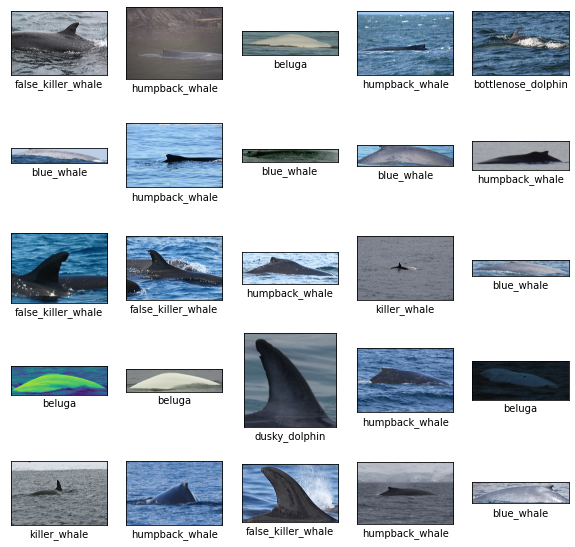

In [24]:
#view the first 25 images
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i, axi in enumerate(ax.flat):
    file = train_data.image[i]
    image = io.imread(train_images_path+file)
    axi.imshow(image)
    axi.set(xticks=[], yticks=[], xlabel = train_data.species[i]);
    cv2.waitKey(0)

Those are some good looking dolphins and whales! Now that our images and species are taken care of, let's remove the columns in the dataframe we will not need for training, just to clean up our space a bit.

In [25]:
#delete columns we don't need
train_data = train_data.drop(axis=1, columns=['individual_id', 'family'])

In [26]:
#one last look at final dataframe
train_data.head()

,image,species
0,0007c33415ce37.jpg,false_killer_whale
1,00087baf5cef7a.jpg,humpback_whale
2,000be9acf46619.jpg,beluga
3,000bef247c7a42.jpg,humpback_whale
4,000c476c11bad5.jpg,bottlenose_dolphin


In [27]:
#number of species
print(f"We have {train_data['species'].nunique()} unique species to send to the model.")

We have 7 unique species to send to the model.


In [28]:
#check shape of dataframe
print(f'We have {train_data.shape[0]} entries and {train_data.shape[1]} columns.')

We have 29525 entries and 2 columns.


# 3. Model Construction and Architecture

During both model trainings, we will shuffle the data, normalize the images, and crop them to 64x64 pixels. In addition, we will augment the images during batching by randomly rotating the images and/or randomly flipping them vertically. These steps can help make the model more robust and learn better because the images are all standardized and shown in more positions. We will  be using Tensorflow layers to construct our models.

For this project we will use one very simple model and one transfer leanring model. Both models will have five layers after its "base" layer. We call it a "base" layer so that we may more easily compare the two models later on. Each model will output to produce the 7 different category options. In addition, each model's input will be with a shape of (64, 64, 3). The five layers after the 'base' layer will be as such:
1. Global Average Pooling
2. Dense layer with 64 filters and activation function ReLU
3. Dropout layer with 0.4 dropout
4. Dense layer with 128 filters and activation function ReLU
5. Output layer using Dense with 7 categories and activation function as 'softmax'

We use ReLU as our activation function because it usually works well with computer vision models and has produced good results in the past. We use dropout which is an effective way to prevent overfitting and reduce the over-generalization error. Our output is 7 since we have 7 species to choose from. Finally, we use softmax because it is able to bring the logistic regression concept into a multi-class setting and has been shown to produce good results. During the making of this notebook, we tried different values for dropout (including 0.2 and 0.8) and we decided to stay with 0.4. In addition, we will use categorical crossentropy for loss measurement and categorical accuracy. We will use an Adam as our optimizer with a learning rate of 0.0001.  

**SIMPLE MODEL:** Our simple model will have a "base" of one Conv2D layer. This is to make it the simplist we can to be able to compare the models later. This Conv2D layer will have 32 filters, a kernel size of 2x2, stride of 1, and activation as ReLU. We use 32 filters because we know that our next dense layer will be 64 filters, we can easily step it up to continue training. After our simple base layer, we have our 5 layers mentioned above. Although we could have used different hyperparameters (such as filter size, stride and activation) we decided to stick with the values presented as they are our go-to when constructing a simple model.

**RESNET50 BASE MODEL:** ResNet50, otherwise known as Residual Networks 50, and which has 50 layers in its neural network, is the base transfer learning model we will use to compare. ResNet50 overcomes the vanishing gradient problem during back propagation by using skip connections throughout its structure. ReNet50 uses two types of blocks, the identity block and convolutional block. For more information on ResNet50: https://blog.devgenius.io/resnet50-6b42934db431 and https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50. We will not be using the last layer of the ResNet50 model, and instead we will use the 5 layers mentioned above to finish the architecture. Lastly, we will use the ImageNet base verison of ResNet50 which was trained on the ImageNet data.

**REASONING:** We chose to compare a very simple model to a transfer learning model to really demonstrate how transfer learning can change your performance and time to train. We specifically chose ResNet50 because it uses skip connections which help avoid the vanishing weight problem (which you can read more about [here](https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484). We chose the hyperparameters we did because they have proven to perform well in other models. 

Note, data preprocessing for the images will be done during the batching and running of the model. Due to space limitations, if we were to edit each image and save it, we would waste time and most likely use up much valuable memory space. For our preprocessing, we will be using ImageDataGenerator which allows us to modify/augment images as we batch them. In that step, we will normalize the images and split into training and testing set. We also will randomly flip them vertically and/or rotate the images. We do this to allow the model to learn more image possiblities of what fin positions could be. We also will have all images resized to 64x64x3 so they are all standard for the model to learn. 

**ResNet50 Architecture**

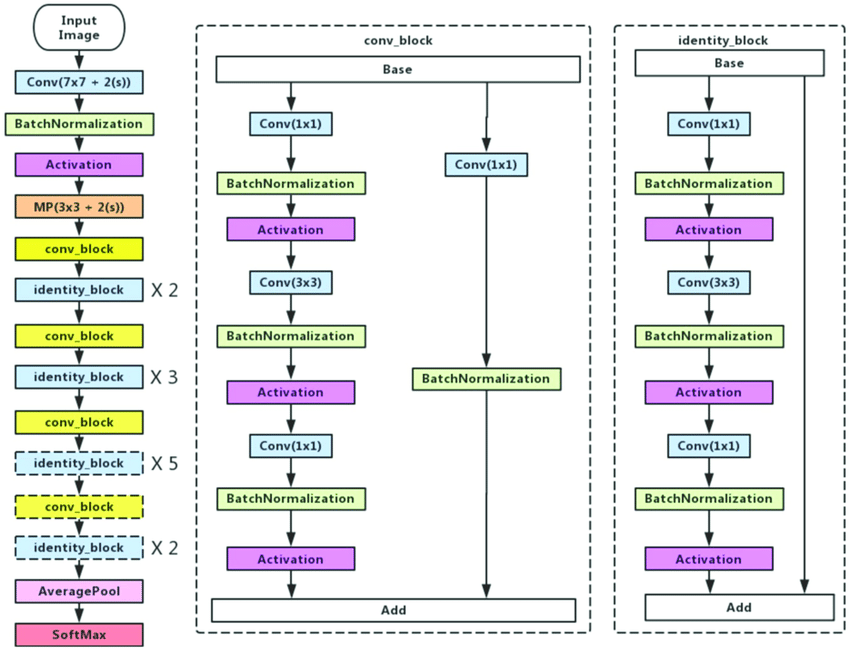
https://www.researchgate.net/figure/Left-ResNet50-architecture-Blocks-with-dotted-line-represents-modules-that-might-be_fig3_331364877



In [29]:
#set globals
BATCH_SIZE = 256
RANDOM_STATE = 49
EPOCHS = 6
NUM_SPECIES = train_data["species"].nunique() #7 classes
pixels = 64
TARGET_SIZE = (pixels, pixels) 
INPUT_SHAPE = (pixels, pixels, 3)

In [30]:
#shuffle data
train_data = shuffle(train_data, random_state=RANDOM_STATE)

In [31]:
# Setup GPU accelerator - configure Strategy
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu) #Assume TPU
except ValueError:
    strategy = tf.distribute.get_strategy() #if not TPU, set default for GPU/CPU

In [32]:
#set up image generator to split into 80/20 train-validation groups
datagen = ImageDataGenerator(validation_split=0.2) 

#set up training batching
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_images_path,
    x_col="image",
    y_col="species",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="categorical",
    target_size=TARGET_SIZE) #resize images to 64x64x3

#set up valid data batching
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_images_path,
    x_col="image",
    y_col="species",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="categorical",
    target_size=TARGET_SIZE) #resize images to 64x64x3

Found 23620 validated image filenames belonging to 7 classes.
Found 5905 validated image filenames belonging to 7 classes.


#### Build and Train Simple Model

In [33]:
with strategy.scope(): #use TPU/GPU strategy

    #define input image size
    input_ = tf.keras.Input(shape=INPUT_SHAPE) #64x64x3

    #image augmentation
    x = layers.Rescaling(1./255.0)(input_) #normalize
    x = layers.RandomFlip('vertical')(x)   #randomly flip
    x = layers.RandomRotation(0.3)(x)      #randomly rotate up to 30 degrees

    #set up base model (simple base)
    x = layers.Conv2D(32, kernel_size=2, strides=(1, 1), activation='relu')(x)

    #set up model which will be the same in each 
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x) 
    x = layers.Dropout(0.4)(x) 
    x = layers.Dense(128, activation='relu')(x) 
    output_ = layers.Dense(NUM_SPECIES, activation='softmax')(x) #output 7 categories/classes

    #make model
    model_1 = tf.keras.models.Model(inputs = input_, 
                                    outputs=output_)

    #compile model
    model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), #set up optimizer with small lr
                    loss = tf.keras.losses.CategoricalCrossentropy(), #set up loss function
                    metrics = [tf.keras.metrics.CategoricalAccuracy()]) #set up performance metric

2022-09-29 10:15:52.239836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 10:15:52.241010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 10:15:52.241681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 10:15:52.242516: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [34]:
#view model summary/structure
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 64, 64, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 63, 63, 32)        416       
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112  

In [35]:
# train model_1
history_model_1 = model_1.fit(train_generator,
                              epochs = EPOCHS,
                              validation_data = valid_generator)

2022-09-29 10:16:16.415413: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/6


2022-09-29 10:16:36.464907: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


93/93 [==============================] - 2254s 24s/step - loss: 1.9370 - categorical_accuracy: 0.1728 - val_loss: 1.9225 - val_categorical_accuracy: 0.1819
Epoch 2/6
93/93 [==============================] - 2125s 23s/step - loss: 1.9126 - categorical_accuracy: 0.1796 - val_loss: 1.9029 - val_categorical_accuracy: 0.1814
Epoch 3/6
93/93 [==============================] - 2155s 23s/step - loss: 1.8999 - categorical_accuracy: 0.1851 - val_loss: 1.8967 - val_categorical_accuracy: 0.1814
Epoch 4/6
93/93 [==============================] - 2018s 22s/step - loss: 1.8934 - categorical_accuracy: 0.1895 - val_loss: 1.8893 - val_categorical_accuracy: 0.1888
Epoch 5/6
93/93 [==============================] - 1975s 21s/step - loss: 1.8846 - categorical_accuracy: 0.2134 - val_loss: 1.8790 - val_categorical_accuracy: 0.2291
Epoch 6/6
93/93 [==============================] - 1972s 21s/step - loss: 1.8737 - categorical_accuracy: 0.2371 - val_loss: 1.8624 - val_categorical_accuracy: 0.2511


In [36]:
#check keys before plotting
history_model_1.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

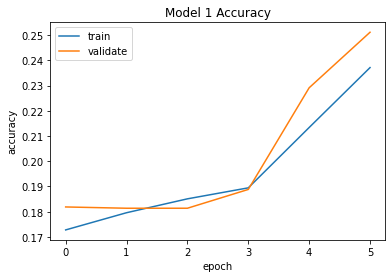

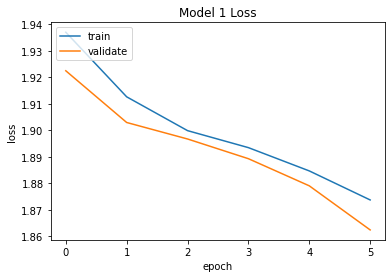

In [37]:
# graph accuracy
plt.plot(history_model_1.history['categorical_accuracy'])
plt.plot(history_model_1.history['val_categorical_accuracy'])
plt.title('Model 1 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

#graph loss
plt.plot(history_model_1.history['loss'])
plt.plot(history_model_1.history['val_loss'])
plt.title('Model 1 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [38]:
#clear memory to make more room
model_1 = None
history_model_1 = None

#### Transfer Learning Model
Redo model with transfer learning from ImageNet using ResNet50

In [39]:
with strategy.scope(): #use TPU/GPU
    
    #set up resnet50 base 
    base_model = tf.keras.applications.resnet50.ResNet50(input_shape=INPUT_SHAPE, 
                                                         include_top=False, 
                                                         weights='imagenet') 
    
    #we set the ResNet base as untrainable so we don't reset/change 
    #its learned weights (the whole reason we are using it)
    base_model.trainable = False
    
    #set input
    input_ = tf.keras.Input(shape=INPUT_SHAPE) #input shape is 64x64x3
    
    #image augmentation
    x = layers.Rescaling(1./255.0)(input_)    #normalize
    x = layers.RandomFlip('vertical')(x)  #randomly flip
    x = layers.RandomRotation(0.3)(x)     #randomly rotate

    #set base model (ResNet50)
    x = base_model(x, training=False) 

    #repeat same top layers as before
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x) 
    x = layers.Dropout(0.4)(x) 
    x = layers.Dense(128, activation='relu')(x) 
    output_ = layers.Dense(NUM_SPECIES, activation='softmax')(x)  #output 7 classes

    #make model
    model_2 = tf.keras.models.Model(inputs = input_, 
                                    outputs=output_)
    
    #compile the model 
    model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), #set optimizer with small lr
                    loss = tf.keras.losses.CategoricalCrossentropy(), #set loss function
                    metrics = [tf.keras.metrics.CategoricalAccuracy()]) #set performance metric

94781440/94765736 [==============================] - 1s 0us/step


In [40]:
#quick look at model
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 64, 64, 3)         0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 64, 64, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1311

In [41]:
# train model_2
history_model_2 = model_2.fit(train_generator,
                              epochs = EPOCHS,
                              validation_data = valid_generator)

Epoch 1/6
93/93 [==============================] - 2014s 22s/step - loss: 1.9618 - categorical_accuracy: 0.1671 - val_loss: 1.8951 - val_categorical_accuracy: 0.2186
Epoch 2/6
93/93 [==============================] - 2000s 22s/step - loss: 1.9099 - categorical_accuracy: 0.1870 - val_loss: 1.8708 - val_categorical_accuracy: 0.2156
Epoch 3/6
93/93 [==============================] - 1972s 21s/step - loss: 1.8886 - categorical_accuracy: 0.2052 - val_loss: 1.8433 - val_categorical_accuracy: 0.2273
Epoch 4/6
93/93 [==============================] - 1954s 21s/step - loss: 1.8704 - categorical_accuracy: 0.2241 - val_loss: 1.8168 - val_categorical_accuracy: 0.2494
Epoch 5/6
93/93 [==============================] - 1975s 21s/step - loss: 1.8494 - categorical_accuracy: 0.2423 - val_loss: 1.7907 - val_categorical_accuracy: 0.2887
Epoch 6/6
93/93 [==============================] - 1969s 21s/step - loss: 1.8242 - categorical_accuracy: 0.2725 - val_loss: 1.7635 - val_categorical_accuracy: 0.3314


In [42]:
#model_2 keys
history_model_2.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

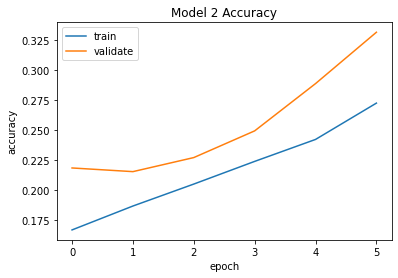

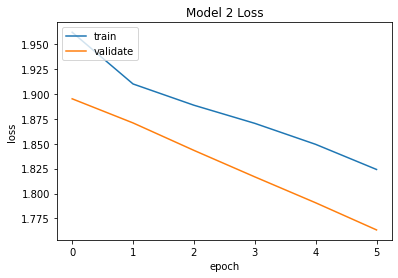

In [43]:
# graph accuracy
plt.plot(history_model_2.history['categorical_accuracy'])
plt.plot(history_model_2.history['val_categorical_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

#graph loss
plt.plot(history_model_2.history['loss'])
plt.plot(history_model_2.history['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# Results

We have successfully trained our two models, the simple model (model 1) and the transfer learning model (model 2). The first thing we can see very quickly is the big difference in loss and accuracy between the simple and transfer learning model; we see that the simple model is learning but with only 6 epochs, it gets ~0.25 accuracy and down to ~1.85 loss. In comparision, the second model learns much faster - it after 6 epochs it has a failry high accuracy and the loss is much lower. Another thing to note is that the validation (testing) set in the second model seemed to perform much better every epoch than did the first model. 

These differences can be summed up to faster learning and a better model with model 2. This is becasue the second model has already learned basic concepts because it was trained on ImageNet. In addition, the second model is much more complex (more than 50 layers!).This is a great example of how transfer learning can help models learn faster and better. 

Somethings to consider belong transfer learning are the hyperparameters. In our simple model, we used a Conv2D layer as our base layer. We tried different hyperparameters (including filters=64, strides=3, and kernel_size=3,3) but it seemed to perform well enough with the parameters we set above. We know in the ResNet50 model, there are many more hyperparameters which were used, however, since it is transfer learning, we are taking that model as is (without changing its hyperparameters) because we want the weights it has already learned. Lastly, we used a fairly small learning rate of 0.0001. If we modified that (larger or smaller) that would probably impact our simple model more than our larger model. We presume that a larger learning rate (0.01 for example) would allow the model to converge faster and perhaps have a better accuracy with only 6 epochs. 

# Conclusion

Overall, we are quite happy with our transfer learning model. We were able to demonstrate how transfer learning can shorten training time and increase performance. Our second model out performed the simple model very quickly. This study was able to complete its goal by successfully identifying our seven species of dolphins and whales based on images of their fins.

To achieve such results, we first visualized the data and cleaned up the dataframe containing the information. We also decreased the number of images by removing species which had few images as well and removing some of the inputs for those species which had too many images. We did this for faster model training as well as to make the dataset more balanced (which helps produce a more performant model). During training, we preprocessed the images by normalizing and augmenting the images in batches. We then trained two models, our simple model and the transfer learning model using ResNet50. Finally, we discussed the results and hyperparameters in the *Results* section. 

In addition to hyperparameter modification (discussed in the *Results* section above), we could have done a few modifications to improve our model(s). First, we could have used more images which would expose the model to more possiblities, positions, shapes, sizes and colors. Image size also played a part in training. We used fairly small images (64x64x3) but the images we were given generally were much larger. We could have used larger image sizes during training such as 100x100, 256x256 or even 500x500. We tried with 256x256 and 100x100 but training was very slow. We also could have used more epochs (such as 10, 20, 50, etc). Because this notebook is for demonstration purposes, we only used a few epochs. However, if you increase the epochs to much, you could have run into overfitting by training it for too long. Some ways to avoid such behavior would be to use early stopping ([Tensorflow link](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)). Lastly, we could have added more layers to either model which may have resulted in better performance as well. 

This study gives way to possible future projects. By using transfer learning in such a way, we can train models to identify a wide variety of things, not just whales and dolphins. Here are a few interesting papers on transfer learning which readers may find useful:
1. https://link.springer.com/chapter/10.1007/978-3-030-01424-7_27
2. https://ieeexplore.ieee.org/abstract/document/8432110
3. https://academic.oup.com/imaiai/article-abstract/5/2/159/2363463?login=false
4. https://www.sciencedirect.com/science/article/abs/pii/S1389041718310933

I hope you enjoyed this notebook! Thank you!

-----End-----